In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention_gl1 as SelfAttention,CrossAttention_gl1 as CrossAttention
import sys,os
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
dnf700 = pd.read_json('evaluation_set/deepnofakes/dnf_700/initial.json')
dnf_eval = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V2.json')
dnf_eval.columns = ['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles300 = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors300 = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf700.keys(), len(articles.keys()), len(article_vectors.keys())

(Index(['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type',
        'urls'],
       dtype='object'),
 Index(['authors', 'headline', 'id', 'type', 'urls'], dtype='object'),
 705,
 705)

In [4]:
num_splits = 5
kf = KFold(n_splits=num_splits)
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 2000
max_sentences = 0
for idx in articles.keys():
    num = len(articles[idx])
    if num>=max_sentences:
        max_sentences = num
        
max_sentences

125

In [5]:
hdl = "George Soros: Trump Will Win Popular Vote by a Landslide but Clinton Victory a 'Done Deal'"
hdl = "Ted Cruz Said 'If Something Happens to Hillary' He'll 'Run as a Democrat Against Trump'"
# hdl = "If You Thought The Trump Child Rape Case In NY Couldn’t Get Much Worse — You Were Wrong"
# hdl = "California Set to Let Public Schools Teach Primarily in Spanish"
dnf700[dnf700.headline==hdl]

,authors,headline,id,type,urls


In [6]:
titles = sorted(dnf700.headline.unique())
len(titles)

698

In [7]:
test_titles = sorted(dnf_eval.headline.unique())
len(test_titles)
test_titles

['(VIDEO) Female College Students Protesting Because ‘Trump is a Rapist’',
 'Assange Confirms: WikiLeaks Didn’t Get Emails From Russian Govt',
 'BREAKING: Fraudulent Clinton Votes Discovered By The “Tens Of Thousands”',
 "Clinton Camp Demands 'Compliant Citizenry' for Master Plan",
 'Clinton Received Debate Questions Week Before Debate',
 "DOJ's Loretta Lynch Tried To Squash Comey's Letter To Congress",
 'Department of Homeland Security Chairman Officially Indicts Hillary Clinton of Treason',
 'Developing: Obama WH admits that Hillary gave ISIS $400 million on accident',
 'Erdoğan: US, the founder of ISIS',
 "FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Healthcare Begins With A Bombshell! » 100percentfedUp.com",
 'FBI Agent Suspected in Hillary Email Leaks Found Dead in Apparent Murder-Suicide',
 'FBI Director Comey’s ‘Leaked’ Memo Explains Why He’s Reopening the Clinton Email Case',
 'FBI director received millions from Clinton Foundation, his brother’s law firm does Clinton’s taxes',
 '

In [8]:
non_test_titles = np.array(list(set(titles)-set(test_titles)))
len(non_test_titles)

650

In [9]:
indices = []
for train_index, val_index in kf.split(non_test_titles):
    indices.append([train_index,val_index])

In [10]:

train_index, val_index = indices[np.random.randint(0,num_splits)]
print(train_index,val_index)
val_titles = non_test_titles[val_index]
train_titles = non_test_titles[train_index]
len(train_titles),len(val_titles),len(test_titles)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

(520, 130, 50)

In [11]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [12]:

def datagen_dnf(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        idx = idx.strip()
        
            
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        if mode=='test':
            hd = dnf_eval[dnf_eval.headline==idx]['headline'].values[0].lower()
            ar_id = dnf_eval[dnf_eval.headline==idx]['id'].values[0]
            cl = dnf_eval[dnf_eval.headline==idx]['claims'].values[0]
            ar_claims.append(cl)
            sentences = articles300[ar_id]
            vectors = article_vectors300[ar_id]
        else:
            try:
                hd = dataframe[dataframe.headline==idx]['headline'].values[0].lower()
                ar_id = dataframe[dataframe.headline==idx]['id'].values[0]
                ar_claims.append('None')
                sentences=articles[ar_id]
                vectors = article_vectors[ar_id]
            except Exception as ex:
                print(ex)
                print(idx)
            
        hds.append(hd)
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
 

In [13]:
tdg = datagen_dnf(train_batchsize,dnf700,mode='train')
vdg = datagen_dnf(val_batchsize,dnf700,mode='val')
test_dg = datagen_dnf(test_batchsize,dnf700,mode='test')

In [14]:
x,y = next(test_dg)

In [15]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 125, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 125, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 125, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 125, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

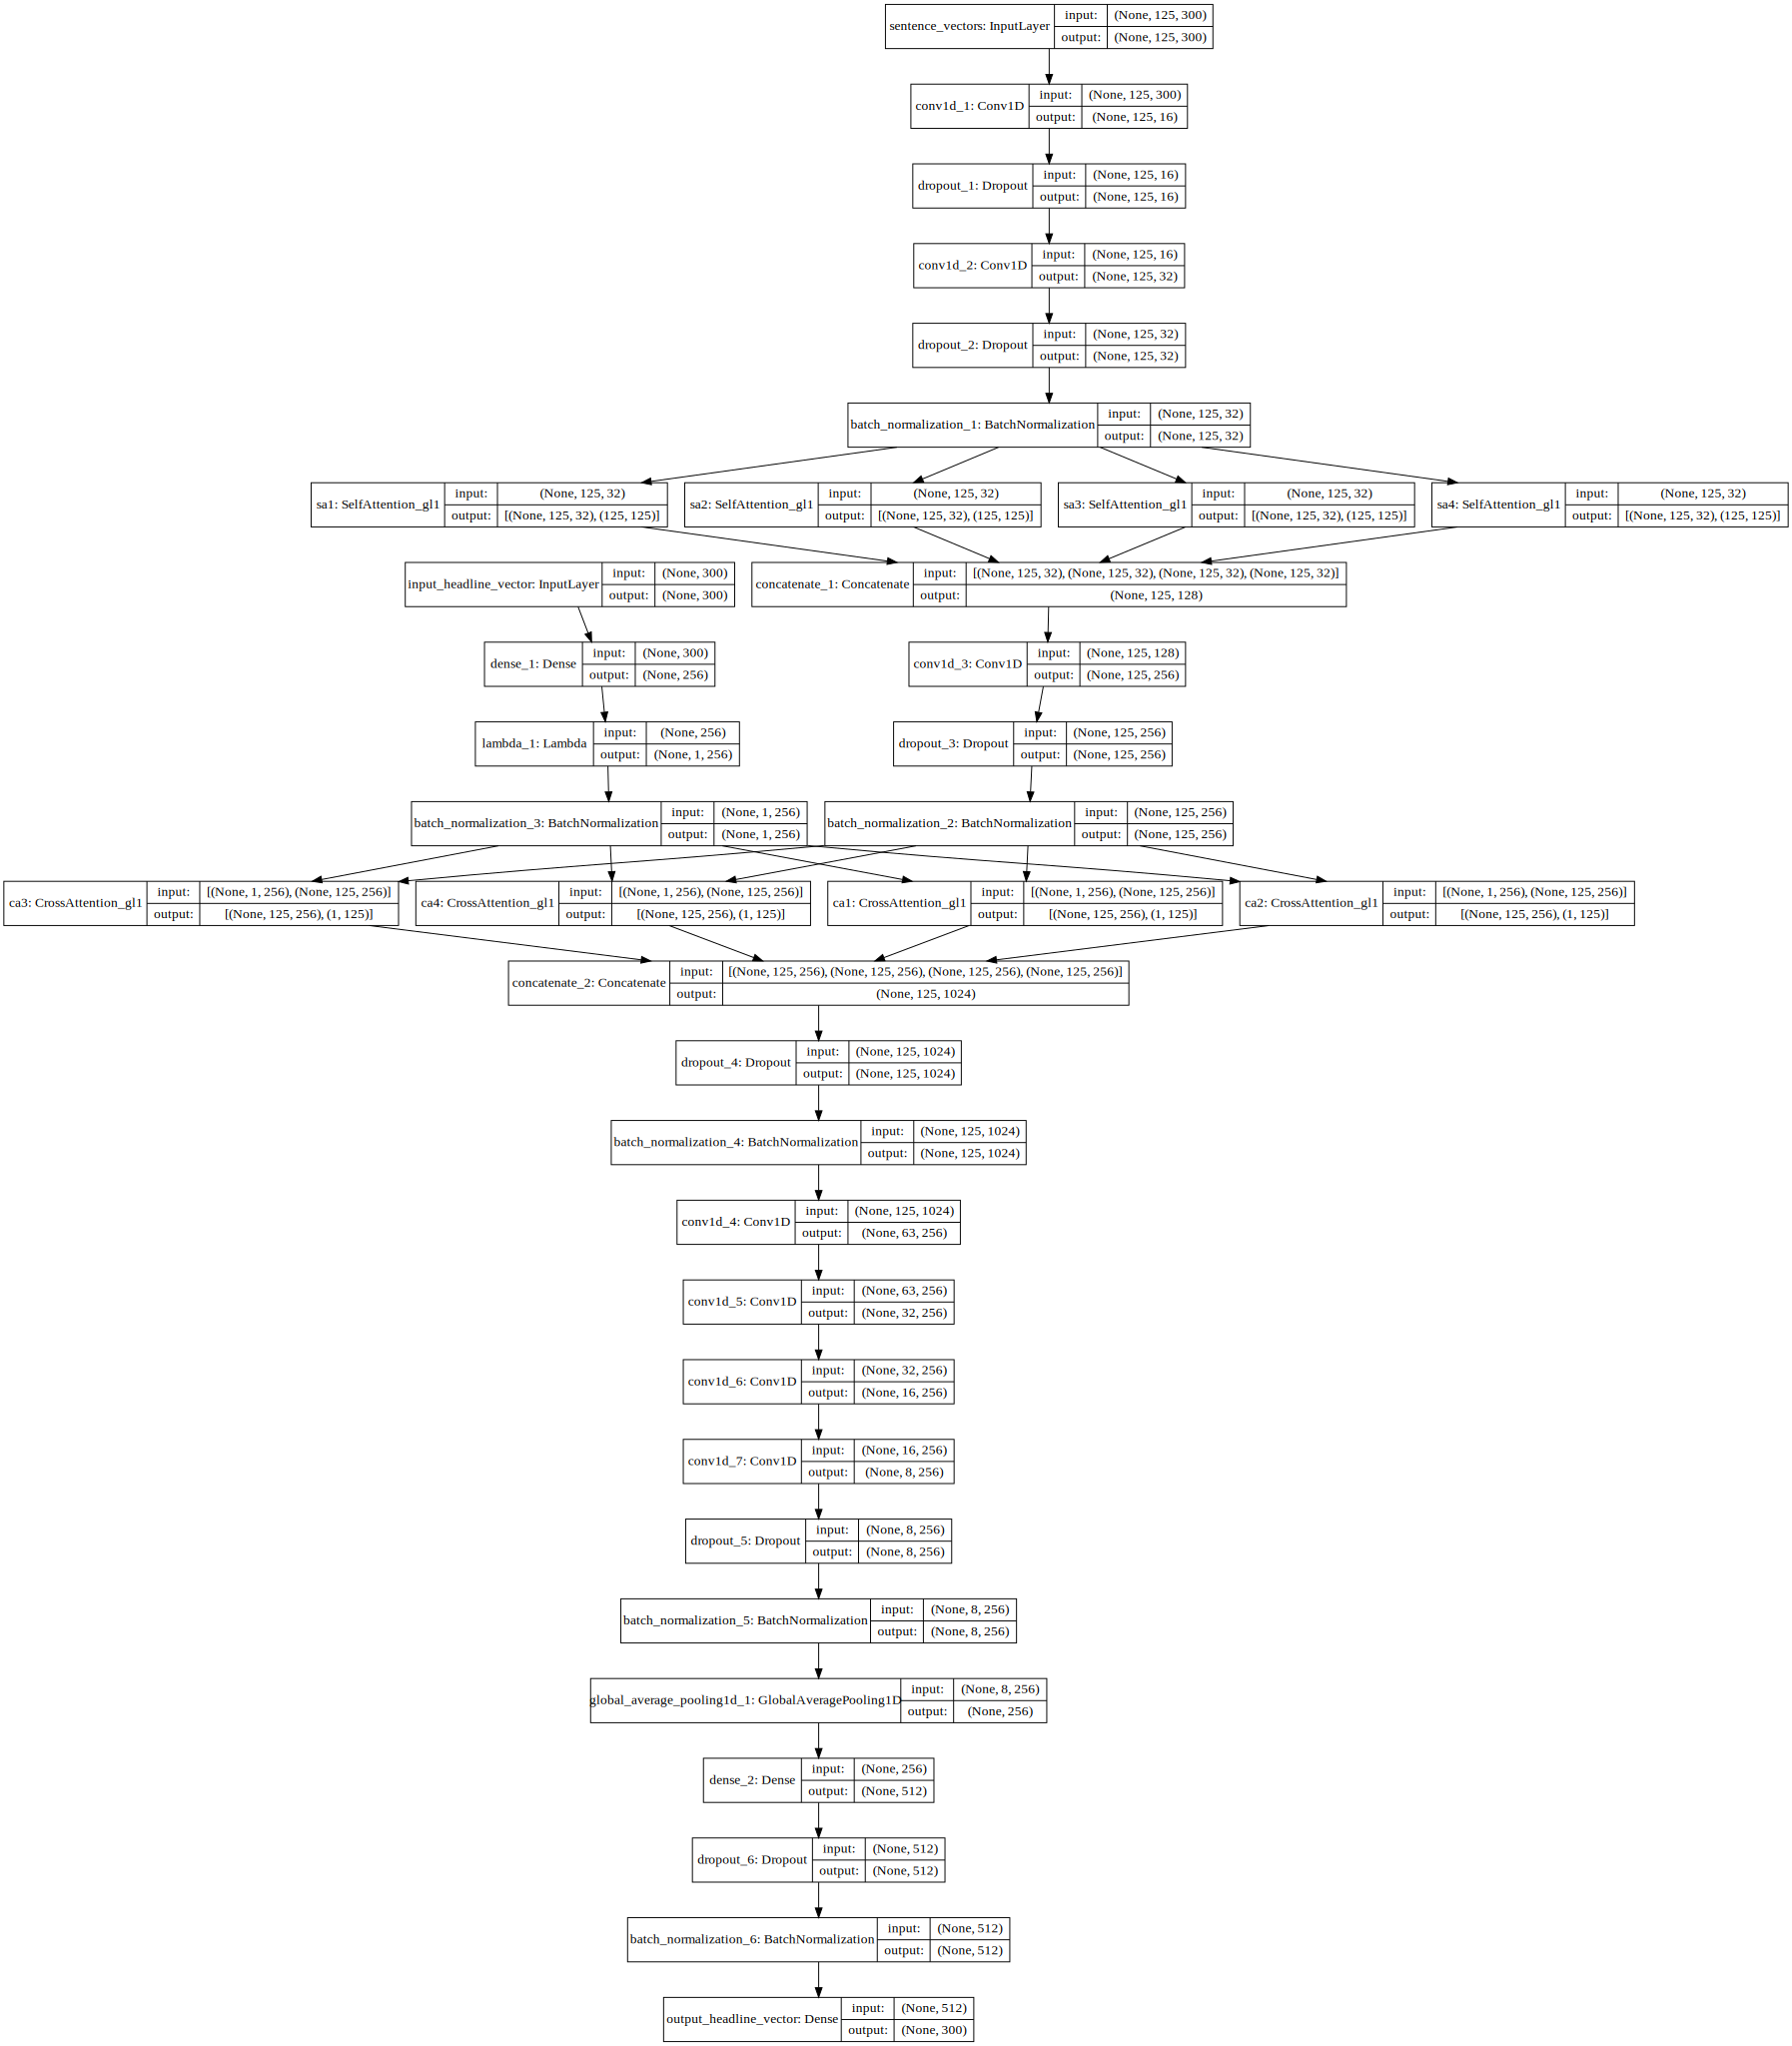

In [16]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1 = SelfAttention(int(conv2.shape[-1]), name = 'sa1')(conv2)
    sent_sa_feat_2, sent_beta_2 = SelfAttention(int(conv2.shape[-1]), name = 'sa2')(conv2)
    sent_sa_feat_3, sent_beta_3 = SelfAttention(int(conv2.shape[-1]), name = 'sa3')(conv2)
    sent_sa_feat_4, sent_beta_4 = SelfAttention(int(conv2.shape[-1]), name = 'sa4')(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
#     repeat = RepeatVector(50)(gap)
#     lstm = LSTM(256,return_sequences=True)(repeat)
    dense1 = Dense(512,activation='relu')(gap)
    dense1 = Dropout(0.5)(dense1)
    dense1 = BatchNormalization()(dense1)
    gen_hd_vector = Dense(300,activation='linear', name='output_headline_vector')(dense1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='mse')
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [17]:
dt = datetime.now()
mc = ModelCheckpoint('weights/dnf700_sa_sent_hd_vector_gl1.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/dnf700_sa_sent_hd_vector_gl1/{0}'.format(dt.timestamp()),write_graph=True)

In [18]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 1/2000
4/4 [==============================] - 22s 5s/step - loss: 1.2834 - val_loss: 0.6184
Epoch 2/2000
4/4 [==============================] - 0s 91ms/step - loss: 1.2600 - val_loss: 0.5519
Epoch 3/2000
4/4 [==============================] - 0s 92ms/step - loss: 1.2479 - val_loss: 0.5158
Epoch 4/2000
4/4 [==============================] - 2s 561ms/step - loss: 1.2369 - val_loss: 0.4915
Epoch 5/2000
4/4 [==============================] - 6s 2s/step - loss: 1.2240 - val_loss: 0.4703
Epoch 6/2000
4/4 [==============================] - 6s 2s/step - loss: 1.2247 - val_loss: 0.4460
Epoch 7/2000
4/4 [==============================] - 6s 1s/step - loss: 1.2088 - val_loss: 0.4267
Epoch 8/2000
4/4 [==============================] - 6s 2s/step - loss: 1.1941 - val_loss: 0.4097
Epoch 9/2000
4/4 [==============================] - 5s 1s/step - loss: 1.1834 - val_loss: 0.3967
Epoch 10/2000
4/4 [==============================] - 5s 1s/step - loss: 1.1889 - val_loss: 0.3818
Epoch 11/2000
4/4 [==

4/4 [==============================] - 7s 2s/step - loss: 0.4480 - val_loss: 0.0276
Epoch 168/2000
4/4 [==============================] - 6s 1s/step - loss: 0.4514 - val_loss: 0.0310
Epoch 169/2000
4/4 [==============================] - 6s 1s/step - loss: 0.4390 - val_loss: 0.0315
Epoch 170/2000
4/4 [==============================] - 6s 2s/step - loss: 0.4328 - val_loss: 0.0326
Epoch 171/2000
4/4 [==============================] - 6s 2s/step - loss: 0.4336 - val_loss: 0.0293
Epoch 172/2000
4/4 [==============================] - 6s 1s/step - loss: 0.4422 - val_loss: 0.0288
Epoch 173/2000
4/4 [==============================] - 6s 2s/step - loss: 0.4372 - val_loss: 0.0304
Epoch 174/2000
4/4 [==============================] - 6s 1s/step - loss: 0.4253 - val_loss: 0.0303
Epoch 175/2000
4/4 [==============================] - 6s 2s/step - loss: 0.4315 - val_loss: 0.0318
Epoch 176/2000
4/4 [==============================] - 6s 2s/step - loss: 0.4326 - val_loss: 0.0331
Epoch 177/2000
4/4 [=====

Epoch 250/2000
4/4 [==============================] - 6s 2s/step - loss: 0.3198 - val_loss: 0.0266
Epoch 251/2000
4/4 [==============================] - 6s 2s/step - loss: 0.3100 - val_loss: 0.0244
Epoch 252/2000
4/4 [==============================] - 6s 2s/step - loss: 0.3009 - val_loss: 0.0232
Epoch 253/2000
4/4 [==============================] - 5s 1s/step - loss: 0.3000 - val_loss: 0.0240
Epoch 254/2000
4/4 [==============================] - 6s 1s/step - loss: 0.3037 - val_loss: 0.0263
Epoch 255/2000
4/4 [==============================] - 5s 1s/step - loss: 0.3062 - val_loss: 0.0252
Epoch 256/2000
4/4 [==============================] - 6s 2s/step - loss: 0.3044 - val_loss: 0.0257
Epoch 257/2000
4/4 [==============================] - 6s 2s/step - loss: 0.3048 - val_loss: 0.0258
Epoch 258/2000
4/4 [==============================] - 6s 1s/step - loss: 0.3027 - val_loss: 0.0225
Epoch 259/2000
4/4 [==============================] - 6s 1s/step - loss: 0.3007 - val_loss: 0.0255
Epoch 260/

Epoch 415/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0118 - val_loss: 0.0113
Epoch 416/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0110
Epoch 417/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0118 - val_loss: 0.0114
Epoch 418/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0110 - val_loss: 0.0085
Epoch 419/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0124 - val_loss: 0.0106
Epoch 420/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0115 - val_loss: 0.0100
Epoch 421/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0104 - val_loss: 0.0093
Epoch 422/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0119 - val_loss: 0.0093
Epoch 423/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0112
Epoch 424/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0123 - val_loss: 0.0102
Epoch 425/

Epoch 580/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0109 - val_loss: 0.0093
Epoch 581/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0104 - val_loss: 0.0096
Epoch 582/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0109 - val_loss: 0.0113
Epoch 583/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0113 - val_loss: 0.0096
Epoch 584/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0112 - val_loss: 0.0132
Epoch 585/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0117 - val_loss: 0.0095
Epoch 586/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0111 - val_loss: 0.0105
Epoch 587/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0100 - val_loss: 0.0119
Epoch 588/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0108 - val_loss: 0.0114
Epoch 589/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0112 - val_loss: 0.0093
Epoch 590/

Epoch 745/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0118 - val_loss: 0.0095
Epoch 746/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0125 - val_loss: 0.0114
Epoch 747/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0117
Epoch 748/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0116 - val_loss: 0.0119
Epoch 749/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0117
Epoch 750/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0108
Epoch 751/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0107
Epoch 752/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0114 - val_loss: 0.0103
Epoch 753/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0090
Epoch 754/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0103 - val_loss: 0.0105
Epoch 755/

Epoch 910/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0126 - val_loss: 0.0115
Epoch 911/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0119 - val_loss: 0.0124
Epoch 912/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0106 - val_loss: 0.0104
Epoch 913/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0124 - val_loss: 0.0089
Epoch 914/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0116
Epoch 915/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0113 - val_loss: 0.0133
Epoch 916/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0118 - val_loss: 0.0099
Epoch 917/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0096
Epoch 918/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0119 - val_loss: 0.0096
Epoch 919/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0104 - val_loss: 0.0098
Epoch 920/

4/4 [==============================] - 5s 1s/step - loss: 0.0113 - val_loss: 0.0109
Epoch 1075/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0091
Epoch 1076/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0117 - val_loss: 0.0105
Epoch 1077/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0109 - val_loss: 0.0100
Epoch 1078/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0102
Epoch 1079/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0108 - val_loss: 0.0113
Epoch 1080/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0127 - val_loss: 0.0104
Epoch 1081/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0111 - val_loss: 0.0092
Epoch 1082/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0112 - val_loss: 0.0103
Epoch 1083/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0115 - val_loss: 0.0103
Epoch 1084/2000


4/4 [==============================] - 6s 2s/step - loss: 0.0133 - val_loss: 0.0104
Epoch 1157/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0120 - val_loss: 0.0116
Epoch 1158/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0112 - val_loss: 0.0110
Epoch 1159/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0109 - val_loss: 0.0113
Epoch 1160/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0108 - val_loss: 0.0089
Epoch 1161/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0124 - val_loss: 0.0099
Epoch 1162/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0119 - val_loss: 0.0105
Epoch 1163/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0115 - val_loss: 0.0087
Epoch 1164/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0121 - val_loss: 0.0110
Epoch 1165/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0108 - val_loss: 0.0096
Epoch 1166/2000


4/4 [==============================] - 6s 1s/step - loss: 0.0112 - val_loss: 0.0098
Epoch 1239/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0114 - val_loss: 0.0098
Epoch 1240/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0129 - val_loss: 0.0100
Epoch 1241/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0122 - val_loss: 0.0114
Epoch 1242/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0104 - val_loss: 0.0102
Epoch 1243/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0112 - val_loss: 0.0086
Epoch 1244/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0119 - val_loss: 0.0092
Epoch 1245/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0107 - val_loss: 0.0123
Epoch 1246/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0134 - val_loss: 0.0121
Epoch 1247/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0101 - val_loss: 0.0097
Epoch 1248/2000


4/4 [==============================] - 6s 2s/step - loss: 0.0114 - val_loss: 0.0096
Epoch 1321/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0106 - val_loss: 0.0111
Epoch 1322/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0120 - val_loss: 0.0095
Epoch 1323/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0115 - val_loss: 0.0096
Epoch 1324/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0113
Epoch 1325/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0111 - val_loss: 0.0107
Epoch 1326/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0112 - val_loss: 0.0095
Epoch 1327/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0106 - val_loss: 0.0090
Epoch 1328/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0111 - val_loss: 0.0101
Epoch 1329/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0103 - val_loss: 0.0096
Epoch 1330/2000


4/4 [==============================] - 6s 2s/step - loss: 0.0112 - val_loss: 0.0095
Epoch 1403/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0118 - val_loss: 0.0102
Epoch 1404/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0103 - val_loss: 0.0090
Epoch 1405/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0118 - val_loss: 0.0095
Epoch 1406/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0112 - val_loss: 0.0114
Epoch 1407/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0111 - val_loss: 0.0099
Epoch 1408/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0106 - val_loss: 0.0105
Epoch 1409/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0106 - val_loss: 0.0112
Epoch 1410/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0104
Epoch 1411/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0103 - val_loss: 0.0103
Epoch 1412/2000


4/4 [==============================] - 6s 2s/step - loss: 0.0113 - val_loss: 0.0096
Epoch 1485/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0139 - val_loss: 0.0097
Epoch 1486/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0114
Epoch 1487/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0114 - val_loss: 0.0110
Epoch 1488/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0098
Epoch 1489/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0110 - val_loss: 0.0095
Epoch 1490/2000
4/4 [==============================] - 7s 2s/step - loss: 0.0106 - val_loss: 0.0101
Epoch 1491/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0121 - val_loss: 0.0105
Epoch 1492/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0109 - val_loss: 0.0104
Epoch 1493/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0116 - val_loss: 0.0096
Epoch 1494/2000


4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0096
Epoch 1567/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0105 - val_loss: 0.0121
Epoch 1568/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0120 - val_loss: 0.0098
Epoch 1569/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0113 - val_loss: 0.0114
Epoch 1570/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0111 - val_loss: 0.0118
Epoch 1571/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0109 - val_loss: 0.0113
Epoch 1572/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0106 - val_loss: 0.0112
Epoch 1573/2000
4/4 [==============================] - 6s 1s/step - loss: 0.0121 - val_loss: 0.0098
Epoch 1574/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0117 - val_loss: 0.9021
Epoch 1575/2000
4/4 [==============================] - 6s 2s/step - loss: 0.0107 - val_loss: 0.0522
Epoch 1576/2000


Epoch 1648/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0107 - val_loss: 0.0103
Epoch 1649/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0112 - val_loss: 0.0113
Epoch 1650/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0117 - val_loss: 0.0108
Epoch 1651/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0114 - val_loss: 0.0097
Epoch 1652/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0106 - val_loss: 0.0119
Epoch 1653/2000
4/4 [==============================] - 4s 953ms/step - loss: 0.0110 - val_loss: 0.0087
Epoch 1654/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0114 - val_loss: 0.0108
Epoch 1655/2000
4/4 [==============================] - 5s 1s/step - loss: 0.0113 - val_loss: 0.0094
Epoch 1656/2000
4/4 [==============================] - 4s 956ms/step - loss: 0.0114 - val_loss: 0.0099
Epoch 1657/2000
4/4 [==============================] - 4s 1s/step - loss: 0.0108 - val_loss: 0

4/4 [==============================] - 3s 662ms/step - loss: 0.0126 - val_loss: 0.0101
Epoch 1811/2000
4/4 [==============================] - 3s 669ms/step - loss: 0.0110 - val_loss: 0.0122
Epoch 1812/2000
4/4 [==============================] - 3s 698ms/step - loss: 0.0118 - val_loss: 0.0103
Epoch 1813/2000
4/4 [==============================] - 3s 692ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 1814/2000
4/4 [==============================] - 2s 569ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 1815/2000
4/4 [==============================] - 3s 676ms/step - loss: 0.0112 - val_loss: 0.0091
Epoch 1816/2000
4/4 [==============================] - 2s 614ms/step - loss: 0.0106 - val_loss: 0.0108
Epoch 1817/2000
4/4 [==============================] - 3s 688ms/step - loss: 0.0100 - val_loss: 0.0117
Epoch 1818/2000
4/4 [==============================] - 3s 664ms/step - loss: 0.0113 - val_loss: 0.0124
Epoch 1819/2000
4/4 [==============================] - 3s 691ms/step - loss: 0.0129 - val

4/4 [==============================] - 2s 445ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 1969/2000
4/4 [==============================] - 2s 417ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 1970/2000
4/4 [==============================] - 2s 421ms/step - loss: 0.0113 - val_loss: 0.0119
Epoch 1971/2000
4/4 [==============================] - 2s 421ms/step - loss: 0.0116 - val_loss: 0.0108
Epoch 1972/2000
4/4 [==============================] - 2s 419ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 1973/2000
4/4 [==============================] - 2s 415ms/step - loss: 0.0113 - val_loss: 0.0097
Epoch 1974/2000
4/4 [==============================] - 2s 417ms/step - loss: 0.0116 - val_loss: 0.0096
Epoch 1975/2000
4/4 [==============================] - 2s 419ms/step - loss: 0.0102 - val_loss: 0.0097
Epoch 1976/2000
4/4 [==============================] - 2s 416ms/step - loss: 0.0124 - val_loss: 0.0108
Epoch 1977/2000
4/4 [==============================] - 2s 418ms/step - loss: 0.0103 - val

In [19]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [20]:
# df_res = pd.DataFrame(hist.history)

In [21]:
# df_res[['loss','val_loss']].plot()

In [22]:
# # df_res[['acc','val_acc']].plot()
# hd_nlp = nlp("What is you name my name is Anthony Gonsalves What is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony Gonsalves!".lower())
# len(hd_nlp[:50])

# Evalutate SST

In [23]:
model.load_weights('weights/dnf700_sa_sent_hd_vector_gl1.hdf5')
model.evaluate_generator(test_dg,steps=5,pickle_safe = True)

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<generator..., use_multiprocessing=True, steps=5)`
  


0.01088762804865837

In [24]:
x,y = next(test_dg)
pred = model.predict(x)

In [25]:
x['headline']

array(['hillary sold weapons to isis, wikileaks confirms',
       'clinton received debate questions week before debate',
       'hillary friend bribed fbi agent and his wife',
       "hillary clinton cut her tax bill by 'donating' $1 million to herself via the clinton foundation?",
       "hillary clinton cut her tax bill by 'donating' $1 million to herself via the clinton foundation?",
       'us officials try to scare voters with terror threat',
       'obama declares his family will move to canada if trump is elected',
       'fbi agent suspected in hillary email leaks found dead in apparent murder-suicide',
       'fbi director received millions from clinton foundation, his brother’s law firm does clinton’s taxes',
       'hillary personally ordered ‘donald duck’ troll campaign',
       'hillary clinton’s “sudden move” of $1.8 billion to qatar central bank stuns financial world',
       'us threatens military hacks on russia’s electric, communications grids over election',
       

In [26]:
test_idx = np.random.randint(0,50)
display(x['headline'][test_idx])

'fbi agent suspected in hillary email leaks found dead in apparent murder-suicide'

In [27]:
x['sentences'][test_idx]

['Walkerville, MD – An FBI agent believed to be responsible for the latest email leaks “pertinent to the investigation” into Hillary Clinton’s private email server while she was Secretary of State, was found dead in an apparent murder-suicide early Saturday morning, according to police.',
 'Investigators believe FBI agent, Michael Brown, 45, shot and killed his 33-year-old wife, Susan Brown, late Friday night before setting the couple’s home on fire and then turning the gun on himself.',
 'Brown was a 12 year veteran of the Washington D.C. Metropolitan Police Department before spending the last six years in the FBI.',
 'Neighbors saw smoke coming from the Brown residence and called 9-1-1 at approximately 11:50 p.m. By the time fire crews arrived on scene minutes later, the entire house was engulfed in flames. “',
 'Mrs. Brown’s death was caused by a gunshot wound prior to the house fire,” Walkerville Police Chief Pat Frederick said, “while Mr. Brown’s single-bullet head wound appears t

# Model Test

In [28]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 125, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 125, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 125, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 125, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [29]:

_, b1 = model_1.predict(x)
_, b2 = model_2.predict(x)
_, b3 = model_3.predict(x)
_, b4 = model_4.predict(x)

In [30]:
best_N = 5
t = b[test_idx][0][:len(x['sentences'][test_idx])].argsort()[-best_N:][::-1]
t

NameError: name 'b' is not defined

In [ ]:
print(len(x['sentences'][test_idx]))
b[test_idx][0][:len(x['sentences'][test_idx])].sum()

In [ ]:
display(x['headline'][test_idx])
display(x['claims'][test_idx])

In [ ]:
for s in t:
    if s>=len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

In [ ]:
print(len(x['sentences'][test_idx]))
h_s_attended_vector = b[test_idx][0][:len(x['sentences'][test_idx])]
h_s_attended_vector.sum()

In [ ]:
df_h_s_attended_vector = pd.DataFrame(h_s_attended_vector)


xw = df_h_s_attended_vector.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
xw_scaled = min_max_scaler.fit_transform(xw)
df_h_s_attended_vector = pd.DataFrame(xw_scaled)

In [ ]:
sns.set(rc={'figure.figsize':(2.0,7.0)})
sns.heatmap(df_h_s_attended_vector, annot=True, cmap='YlGnBu', )

# Between Sentences

In [ ]:
model_s1 = Model(model.inputs,model.get_layer(name='sa1').output)
model_s2 = Model(model.inputs,model.get_layer(name='sa2').output)
model_s3 = Model(model.inputs,model.get_layer(name='sa3').output)
model_s4 = Model(model.inputs,model.get_layer(name='sa4').output)
model_s1.summary()
model_s2.summary()
model_s3.summary()
model_s4.summary()

In [ ]:
_, sb1 = model_s1.predict([x['sentence_vectors'],x['input_headline_vector']])
_, sb2 = model_s2.predict(x)
_, sb3 = model_s3.predict(x)
_, sb4 = model_s4.predict(x)

In [ ]:
sb = sb1[test_idx]#+sb2[test_idx]+sb3[test_idx]+sb4[test_idx]
sb = sb[:len(x['sentences'][test_idx]),:len(x['sentences'][test_idx])]

sb.shape

In [ ]:
df_sb = pd.DataFrame(sb)


# zx = df_sb.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# zx_scaled = min_max_scaler.fit_transform(zx)
# df_sb = pd.DataFrame(zx_scaled)

In [ ]:
sns.set(rc={'figure.figsize':(14.0,12.0)})
sns.heatmap(pd.DataFrame(df_sb),annot=True,cmap='YlGnBu')

In [ ]:
pd.DataFrame(x['sentences'][test_idx])